In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from lhereader import LHEReader
from itertools import islice
import torch
from torch import nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve

from HiggstrahlungClassifier import *

In [2]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
### Import Files, convert LHE --> pd dataframe    ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
bkg_file = "Datasets/ee_Zbb_noH.lhe"
sig_file = "Datasets/ee_ZH_Zbb.lhe"

smear = 0.1;
df_bkg = MakeDF_bbZ(bkg_file, smear)
df_sig = MakeDF_bbZ(sig_file, smear)

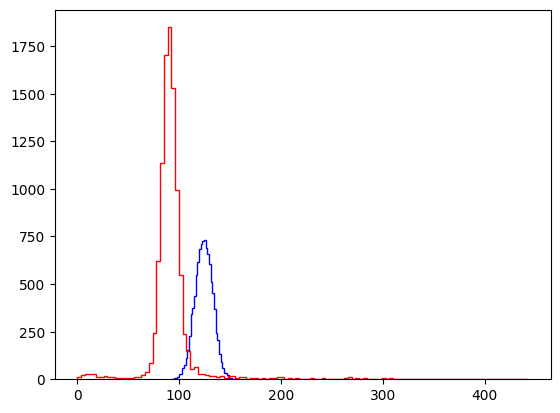

In [3]:
plt.hist(df_sig['m_bb'], bins=40, histtype='step', color='b');
plt.hist(df_bkg['m_bb'], bins=120, histtype='step', color='r');
# plt.yscale('log')

In [4]:
df_sig

,m_bb,px_Z,py_Z,pz_Z,E_Z,px_b1,py_b1,pz_b1,E_b1,px_b2,py_b2,pz_b2,E_b2
0,122.515717,-54.483132,-83.768607,201.484103,242.686395,49.494609,86.390659,-61.466272,117.103608,4.988524,-2.622053,-140.017831,140.209998
1,124.209038,95.905675,-103.365653,-175.215052,242.688941,-106.610367,50.698835,164.138824,202.236954,10.704692,52.666818,11.076227,55.074104
2,126.870454,-138.360995,-165.363326,-63.987169,242.689933,81.812471,166.482459,22.305460,186.893855,56.548524,-1.119133,41.681708,70.416212
3,127.191804,-123.804104,-184.438714,35.197744,242.691631,-12.121588,-4.036898,-20.254832,24.404460,135.925692,188.475612,-14.942911,232.903909
4,124.535288,190.692101,9.701216,118.849510,242.689201,-144.528356,42.038015,-47.978965,158.049712,-46.163745,-51.739231,-70.870544,99.261087
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,100.594956,120.697477,166.996752,-90.153773,242.690648,-116.432853,-149.233041,118.423970,223.323613,-4.264624,-17.763712,-28.270196,33.985739
9996,129.317399,-206.888041,71.164921,52.116154,242.690034,159.569506,-38.430230,19.466621,165.349174,47.318535,-32.734691,-71.582775,91.960793
9997,133.449230,-100.555874,111.303250,167.578443,242.688449,104.112494,-131.303101,-166.745523,236.444655,-3.556620,19.999851,-0.832921,20.866896
9998,130.337341,-214.555983,-48.362292,47.012327,242.690320,212.842765,75.006676,-39.232065,229.105410,1.713218,-26.644384,-7.780262,28.204269


In [5]:
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###
###   Define new DFs with different features   ###
### ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~ ###

df_sig_noZ = df_sig.drop(columns=['px_Z', 'py_Z', 'pz_Z', 'E_Z'])
df_bkg_noZ = df_bkg.drop(columns=['px_Z', 'py_Z', 'pz_Z', 'E_Z'])

df_sig_nombb = df_sig.drop(columns=['m_bb'])
df_bkg_nombb = df_bkg.drop(columns=['m_bb'])

df_sig_noZ_nombb = df_sig.drop(columns=['m_bb', 'px_Z', 'py_Z', 'pz_Z', 'E_Z'])
df_bkg_noZ_nombb = df_bkg.drop(columns=['m_bb', 'px_Z', 'py_Z', 'pz_Z', 'E_Z'])

df_sig_mbb = df_sig[['m_bb']]
df_bkg_mbb = df_bkg[['m_bb']]

In [6]:
print(np.shape(df_sig_noZ_nombb))
df_sig_noZ_nombb_small = df_sig_noZ_nombb.iloc[:-9000]
df_bkg_noZ_nombb_small = df_bkg_noZ_nombb.iloc[:-9000]

print(np.shape(df_sig_noZ_nombb_small))

(10000, 8)
(1000, 8)


# Train NN 

In [9]:
es = 25; arch =[32, 16]
clf_all = HiggsNN(df_sig, df_bkg, epochs = es, layers_and_nodes=arch)
clf_noZ = HiggsNN(df_sig_noZ, df_bkg_noZ, epochs = es, layers_and_nodes=arch)
clf_nombb = HiggsNN(df_sig_nombb, df_bkg_nombb, epochs = es, layers_and_nodes=arch)
clf_noZ_nombb = HiggsNN(df_sig_noZ_nombb, df_bkg_noZ_nombb, epochs = es, layers_and_nodes=arch)
clf_mbb = HiggsNN(df_sig_mbb, df_bkg_mbb, epochs = es, layers_and_nodes=arch)
clf_all.fit()
clf_noZ.fit()
clf_nombb.fit()
clf_noZ_nombb.fit()
clf_mbb.fit()

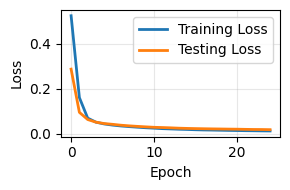

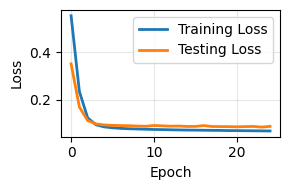

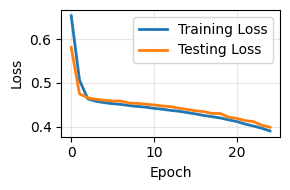

In [10]:
clf_all.plot_loss(train=True, test=True)
clf_noZ.plot_loss(train=True, test=True)
clf_noZ_nombb.plot_loss(train=True, test=True)

1000


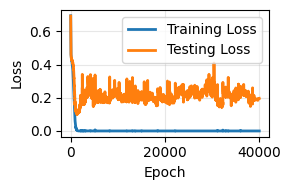

In [14]:
################ Overtraining ... can see double descent ?  ############## 
es = 40000
print(len(df_sig_noZ_nombb_small))
clf_noZ_nombb_small = HiggsNN(df_sig_noZ_nombb_small, df_bkg_noZ_nombb_small, epochs = es, batch_size=32,
                              lr=1e-4, weight_decay=0, layers_and_nodes=[32, 16, 16])
clf_noZ_nombb_small.fit()
clf_noZ_nombb_small.plot_loss(train=True, test=True)
##########################################################################

0.99910525 0.9942967500000001 0.99945425 0.90327525


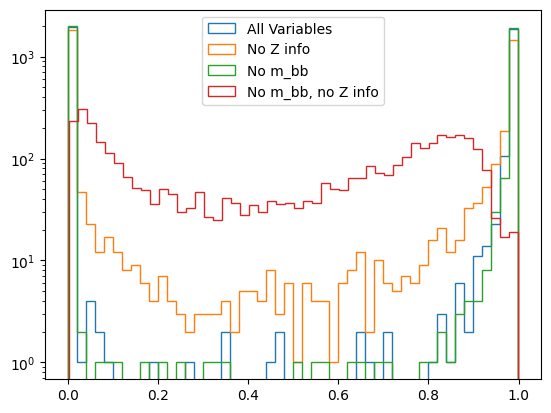

In [15]:
### Evaluate on test data ###
scores_all = clf_all.predict_scores()
scores_noZ = clf_noZ.predict_scores()
scores_nombb = clf_nombb.predict_scores()
scores_noZ_nombb = clf_noZ_nombb.predict_scores()
scores_mbb = clf_mbb.predict_scores()

### Plot AUC ###
bins=50
plt.hist(scores_all, bins=bins, histtype='step');
plt.hist(scores_noZ, bins=bins, histtype='step');
plt.hist(scores_nombb, bins=bins, histtype='step');
plt.hist(scores_noZ_nombb, bins=bins, histtype='step')
# plt.hist(scores_mbb, bins=bins, histtype='step')
plt.yscale('log')
plt.legend(['All Variables', 'No Z info', 'No m_bb', 'No m_bb, no Z info', 'm_bb ONLY'])
print(clf_all.roc_auc(), clf_noZ.roc_auc(), clf_nombb.roc_auc(), clf_noZ_nombb.roc_auc())

# Scaling Laws

In [348]:
#########################
##  Define the models  ##
#########################
layers_and_nodes = [
    [4 ,  4], [8 ,  8], [12, 12], [16, 16], 
    [24, 24], [32, 32], [64, 64], [96, 96], [128, 128], 
    [256, 256], [512, 512], [1024, 1024], 
    # [2048, 2048]
]
training_samples = [ 100, 250, 500, 750, 1000, 2500, 5000, 7500,  10000 ] 

In [349]:
#################################################### 
#           SCALING - PARAMETERS vs LOSS           #
#   Train each model, record AUC, train/test loss  #
####################################################
mlps_p = [];  params = [];
aucs_p, train_losses_p, test_losses_p = [], [], []
n_repeats = 10
for i, ln in enumerate(layers_and_nodes):  
    auc_runs, train_loss_runs, test_loss_runs = [], [], []
    print(f'on model {i+1} of {len(layers_and_nodes)}')
    ## Avg over 10 repeats 
    for r in range(n_repeats):
        mlp = HiggsNN(df_sig[:500], df_bkg[:500], epochs = 20, 
                      batch_size=128, lr=1e-3, weight_decay=1e-4, 
                      layers_and_nodes=ln)
        mlp.fit()
        y, scores = mlp.yv.numpy(), mlp.predict_scores()
        auc_runs.append(roc_auc_score(y, scores))
        # Take last 5 epochs as 'final loss' (( np.mean(m.train_losses[-5:]) ))  ... or min loss  
        train_loss_runs.append(min(mlp.train_losses)) 
        test_loss_runs.append(min(mlp.test_losses))
    ## Append the last MLP, and the nparams of last MLP
    mlps_p.append(mlp)
    params.append(mlp.nparams())
    ## Append the mean scores from the repeats 
    aucs_p.append(np.mean(auc_runs))
    train_losses_p.append(np.mean(train_loss_runs))
    test_losses_p.append(np.mean(test_loss_runs))
#################################################### 
#             SCALING - DATA vs LOSS               #
#   Train each model, record AUC, train/test loss  #
####################################################
mlps_d = [];  sample_sizes = [];
aucs_d, train_losses_d, test_losses_d = [], [], []
n_repeats = 10
for i, size in enumerate(training_samples):  
    auc_runs, train_loss_runs, test_loss_runs = [], [], []
    print(f'on dataset {i+1} of {len(training_samples)}')
    ## Avg over 10 repeats 
    for r in range(n_repeats):
        mlp = HiggsNN(df_sig[:size], df_bkg[:size], epochs = 20, 
                      batch_size=128, lr=1e-3, weight_decay=1e-4, 
                      layers_and_nodes=[32, 32])
        mlp.fit()
        y, scores = mlp.yv.numpy(), mlp.predict_scores()
        auc_runs.append(roc_auc_score(y, scores))
        # Take last 5 epochs as 'final loss' (( np.mean(m.train_losses[-5:]) ))  ... or min loss  
        train_loss_runs.append(min(mlp.train_losses)) 
        test_loss_runs.append(min(mlp.test_losses))
    ## Append the last MLP, and the sample size
    mlps_d.append(mlp)
    sample_sizes.append(training_samples[i])
    ## Append the mean scores from the repeats 
    aucs_d.append(np.mean(auc_runs))
    train_losses_d.append(np.mean(train_loss_runs))
    test_losses_d.append(np.mean(test_loss_runs))

on model 1 of 12
on model 2 of 12
on model 3 of 12
on model 4 of 12
on model 5 of 12
on model 6 of 12
on model 7 of 12
on model 8 of 12
on model 9 of 12
on model 10 of 12
on model 11 of 12
on model 12 of 12
on dataset 1 of 9
on dataset 2 of 9
on dataset 3 of 9
on dataset 4 of 9
on dataset 5 of 9
on dataset 6 of 9
on dataset 7 of 9
on dataset 8 of 9
on dataset 9 of 9


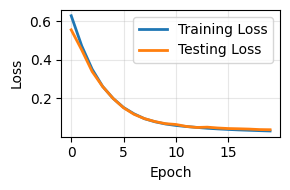

In [350]:
mlps_p[9].plot_loss(train=True, test=True)

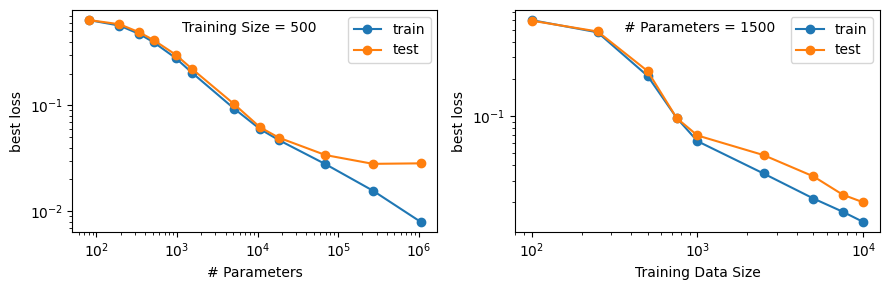

In [351]:
fig, ax = plt.subplots(1, 2, figsize=(9,3))
ax[0].loglog(params, train_losses_p, marker='o')
ax[0].loglog(params, test_losses_p, marker='o')
ax[1].loglog(sample_sizes, train_losses_d, marker='o')
ax[1].loglog(sample_sizes, test_losses_d, marker='o')
ax[0].set_xlabel('# Parameters')
ax[1].set_xlabel('Training Data Size')
ax[0].set_ylabel('best loss')
ax[1].set_ylabel('best loss')
ax[0].legend(['train', 'test'])
ax[1].legend(['train', 'test'])
ax[0].text(0.3, 0.95, "Training Size = 500", transform=ax[0].transAxes, va="top", ha="left")
ax[1].text(0.3, 0.95, "# Parameters = 1500", transform=ax[1].transAxes, va="top", ha="left")

plt.tight_layout()

# Compute-Optimal Scaling

In [352]:
## Loop thru layers_nodes, data 

mlps_p = [];  
n_repeats = 5
n_epochs = 100
compute_dict = {'compute': [],  'params': [], 'data': [], 
                'auc': [], 'tr_loss': [], 'te_loss': []  }

## Loop over L_N
for i, ln in enumerate(layers_and_nodes): 
    print(f'on model {i+1} of {len(layers_and_nodes)}')
    ## Loop over Data 
    # mean_stats = {'data': [], 'auc': [], 'tr_loss': [], 'te_loss': [] }
    for j, size in enumerate(training_samples):
        print(f'   on data size {j+1} of {len(training_samples)}')
        auc_runs, train_losses_runs, test_losses_runs = [], [], []
        # mlps_d.append(mlp)
        ## Avg over 10 repeats 
        for r in range(n_repeats):
            mlp = HiggsNN(df_sig[:size], df_bkg[:size], epochs = n_epochs, 
                      batch_size=128, lr=1e-3, weight_decay=1e-4, 
                      layers_and_nodes=ln)
            mlp.fit()
            y, scores = mlp.yv.numpy(), mlp.predict_scores()
            auc_runs.append(roc_auc_score(y, scores))
            # Take last 5 epochs as 'final loss' (( np.mean(m.train_losses[-5:]) ))  ... or min loss  
            train_losses_runs.append(mlp.train_losses) 
            test_losses_runs.append(mlp.test_losses)
        ## Define Compute, have 
        NumberOfSteps = int(n_epochs * np.ceil(0.8*2*size / 128))
        compute_dict['compute'].append(mlp.nparams()*NumberOfSteps)
        compute_dict['params'].append(mlp.nparams())
        compute_dict['data'].append(size)
        compute_dict['auc'].append(np.mean(auc_runs))
        compute_dict['tr_loss'].append(np.mean(train_losses_runs, axis=0))
        compute_dict['te_loss'].append(np.mean(test_losses_runs, axis=0))
    # print(compute_dict)
print('done!')

on model 1 of 12
   on data size 1 of 9
   on data size 2 of 9
   on data size 3 of 9
   on data size 4 of 9
   on data size 5 of 9
   on data size 6 of 9
   on data size 7 of 9
   on data size 8 of 9
   on data size 9 of 9
on model 2 of 12
   on data size 1 of 9
   on data size 2 of 9
   on data size 3 of 9
   on data size 4 of 9
   on data size 5 of 9
   on data size 6 of 9
   on data size 7 of 9
   on data size 8 of 9
   on data size 9 of 9
on model 3 of 12
   on data size 1 of 9
   on data size 2 of 9
   on data size 3 of 9
   on data size 4 of 9
   on data size 5 of 9
   on data size 6 of 9
   on data size 7 of 9
   on data size 8 of 9
   on data size 9 of 9
on model 4 of 12
   on data size 1 of 9
   on data size 2 of 9
   on data size 3 of 9
   on data size 4 of 9
   on data size 5 of 9
   on data size 6 of 9
   on data size 7 of 9
   on data size 8 of 9
   on data size 9 of 9
on model 5 of 12
   on data size 1 of 9
   on data size 2 of 9
   on data size 3 of 9
   on data size 4 

(108,) (108, 100) (108,) (108, 100)


Text(0, 0.5, 'Test Loss')

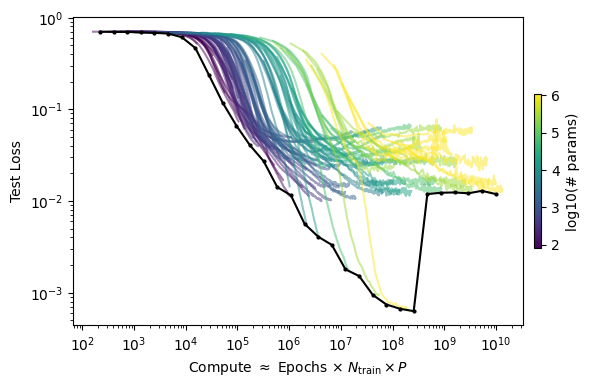

In [354]:
epoch_frac = np.arange(1, n_epochs+1) / n_epochs 

C_tot = np.array(compute_dict['compute'])        
L     = np.array(compute_dict['te_loss']) 
P     = np.array(compute_dict['params'])
C_curve = C_tot[:, None] * epoch_frac[None,:]
print(C_tot.shape, L.shape, P.shape, C_curve.shape)

plt.figure(figsize=(7,4))
norm = plt.Normalize(np.log10(np.min(P)), np.log10(np.max(P)))
for i in range(len(C_tot)):
    plt.loglog(C_curve[i], L[i], alpha=0.5, color=plt.cm.viridis(norm(np.log10(P[i]))))
ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
plt.colorbar(sm, ax=ax, label='log10(# params)',  pad=0.02, shrink=0.5)

# Log-bins 
nbins = 30
edges = np.logspace(np.log10(C_curve.min()), np.log10(C_curve.max()), nbins+1)
minLs, BinCenters = [], []; 
for i in range(len(edges)-1):
    # print(edges[i], edges[i+1])
    ComputeInBin = (C_curve.ravel() > edges[i]) & (C_curve.ravel() < edges[i+1])
    # print(C_curve.ravel()[ComputeInBin])
    # print(L.ravel()[ComputeInBin])
    minLs.append(min(L.ravel()[ComputeInBin]))
    BinCenters.append(np.sqrt(edges[i]*edges[i+1]))
plt.loglog(BinCenters, minLs, marker='o', markersize=2, color='k')
plt.xlabel(r'Compute $\approx$ Epochs $\times$ $N_{\text{train}} \times P$ ')   
plt.ylabel(r'Test Loss')   

(117,) (117, 50) (117,) (117, 50)


Text(0, 0.5, 'Test Loss')

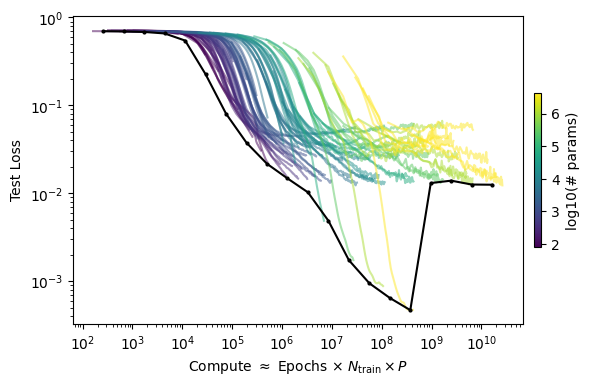

In [346]:
epoch_frac = np.arange(1, n_epochs+1) / n_epochs 

C_tot = np.array(compute_dict['compute'])        
L     = np.array(compute_dict['te_loss']) 
P     = np.array(compute_dict['params'])
C_curve = C_tot[:, None] * epoch_frac[None,:]
print(C_tot.shape, L.shape, P.shape, C_curve.shape)

plt.figure(figsize=(7,4))
norm = plt.Normalize(np.log10(np.min(P)), np.log10(np.max(P)))
for i in range(len(C_tot)):
    plt.loglog(C_curve[i], L[i], alpha=0.5, color=plt.cm.viridis(norm(np.log10(P[i]))))
ax = plt.gca()
sm = plt.cm.ScalarMappable(norm=norm, cmap='viridis')
sm.set_array([])
plt.colorbar(sm, ax=ax, label='log10(# params)',  pad=0.02, shrink=0.5)

# Log-bins 
nbins = 20
edges = np.logspace(np.log10(C_curve.min()), np.log10(C_curve.max()), nbins+1)
minLs, BinCenters = [], []; 
for i in range(len(edges)-1):
    # print(edges[i], edges[i+1])
    ComputeInBin = (C_curve.ravel() > edges[i]) & (C_curve.ravel() < edges[i+1])
    # print(C_curve.ravel()[ComputeInBin])
    # print(L.ravel()[ComputeInBin])
    minLs.append(min(L.ravel()[ComputeInBin]))
    BinCenters.append(np.sqrt(edges[i]*edges[i+1]))
plt.loglog(BinCenters, minLs, marker='o', markersize=2, color='k')
plt.xlabel(r'Compute $\approx$ Epochs $\times$ $N_{\text{train}} \times P$ ')   
plt.ylabel(r'Test Loss')   

(117,) (117, 10) (117, 10)


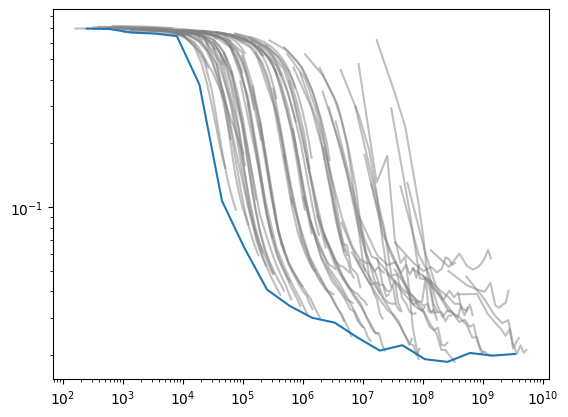

In [304]:
epoch_frac = np.arange(1, n_epochs+1) / n_epochs 

C_tot = np.array(compute_dict['compute'])        
L     = np.array(compute_dict['te_loss']) 
C_curve = C_tot[:, None] * epoch_frac[None,:]
print(C_tot.shape, L.shape, C_curve.shape)

for i in range(len(C_tot)):
    if i%1==0: plt.loglog(C_curve[i], L[i], alpha=0.5, color='gray')

# Log-bins 
nbins = 20
edges = np.logspace(np.log10(C_curve.min()), np.log10(C_curve.max()), nbins+1)
minLs, BinCenters = [], []; 
for i in range(len(edges)-1):
    # print(edges[i], edges[i+1])
    ComputeInBin = (C_curve.ravel() > edges[i]) & (C_curve.ravel() < edges[i+1])
    # print(C_curve.ravel()[ComputeInBin])
    # print(L.ravel()[ComputeInBin])
    minLs.append(min(L.ravel()[ComputeInBin]))
    BinCenters.append(np.sqrt(edges[i]*edges[i+1]))
plt.loglog(BinCenters, minLs)

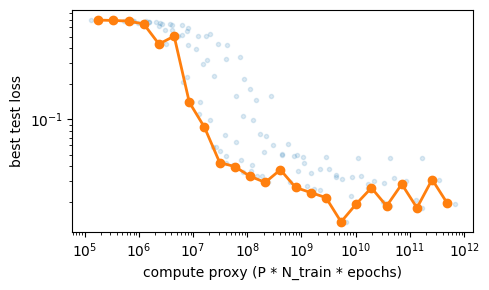

In [139]:
C = compute_PS.ravel()
Lloss = test_PS.ravel()

# log-bins in compute
bins = np.logspace(np.log10(C.min()), np.log10(C.max()), 25)
which = np.digitize(C, bins)

C_mid, L_best = [], []
for b in range(1, len(bins)):
    m = which == b
    if np.any(m):
        C_mid.append(np.sqrt(bins[b-1]*bins[b]))
        L_best.append(Lloss[m].min())

plt.figure(figsize=(5,3))
plt.loglog(C, Lloss, '.', alpha=0.15)          # faint cloud
plt.loglog(C_mid, L_best, '-o', lw=2)          # bold frontier
plt.xlabel('compute proxy (P * N_train * epochs)')
plt.ylabel('best test loss')
plt.tight_layout()
plt.show()
